In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [50]:
# Function to fetch data
def fetch_data(ticker, start, end):
    """
    Fetch historical stock data using yfinance.
    """
    data = yf.download(ticker, start=start, end=end)
    data.dropna(inplace=True)
    return data

In [51]:
data.index = pd.to_datetime(data.index).tz_localize(None)

In [52]:
# Flatten MultiIndex columns
def flatten_columns(data):
    """
    Flatten MultiIndex columns to single-level for easier access.
    """
    data.columns = ['_'.join(filter(None, col)) for col in data.columns]
    return data

In [53]:
# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    data['SMA'] = data['Close_AAPL'].rolling(window=window).mean()
    data['StdDev'] = data['Close_AAPL'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (2 * data['StdDev'])
    data['Lower Band'] = data['SMA'] - (2 * data['StdDev'])
    return data


In [54]:
# Function to generate signals
def generate_signals(data):
    """
    Generate buy and sell signals with corrected column references.
    """
    data['Buy Signal'] = np.nan
    data['Sell Signal'] = np.nan
    data.loc[data['Close_AAPL'] < data['Lower Band'], 'Buy Signal'] = data['Close_AAPL']
    data.loc[data['Close_AAPL'] > data['Upper Band'], 'Sell Signal'] = data['Close_AAPL']
    return data

In [55]:
print(data.columns)

Index(['Adj Close_AAPL', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'SMA', 'StdDev', 'Upper Band', 'Lower Band',
       'Buy Signal', 'Sell Signal'],
      dtype='object')


In [56]:
print(data.head())
print(data.info())

            Adj Close_AAPL  Close_AAPL  High_AAPL   Low_AAPL  Open_AAPL  \
Date                                                                      
2018-01-02       40.524334   43.064999  43.075001  42.314999  42.540001   
2018-01-03       40.517284   43.057499  43.637501  42.990002  43.132500   
2018-01-04       40.705494   43.257500  43.367500  43.020000  43.134998   
2018-01-05       41.168926   43.750000  43.842499  43.262501  43.360001   
2018-01-08       41.016029   43.587502  43.902500  43.482498  43.587502   

            Volume_AAPL  SMA  StdDev  Upper Band  Lower Band  Buy Signal  \
Date                                                                       
2018-01-02    102223600  NaN     NaN         NaN         NaN         NaN   
2018-01-03    118071600  NaN     NaN         NaN         NaN         NaN   
2018-01-04     89738400  NaN     NaN         NaN         NaN         NaN   
2018-01-05     94640000  NaN     NaN         NaN         NaN         NaN   
2018-01-08     822

In [57]:
def backtest_strategy(data, initial_balance=10000):
    """
    Backtest the trading strategy.
    """
    balance = initial_balance
    shares = 0
    for i in range(1, len(data)):
        # Buy signal
        if data['Buy Signal'][i] == 1 and balance > 0:
            shares = balance / data['Close'][i]
            balance = 0
            print(f"Buying {shares:.2f} shares at ${data['Close'][i]:.2f}")

        # Sell signal
        elif data['Sell Signal'][i] == 1 and shares > 0:
            balance = shares * data['Close'][i]
            shares = 0
            print(f"Selling at ${data['Close'][i]:.2f}, Balance: ${balance:.2f}")

    # Final portfolio value
    if shares > 0:
        balance += shares * data['Close'].iloc[-1]

    return balance

final_balance = backtest_strategy(data)
print(f"Final Portfolio Value: ${final_balance:.2f}")


Final Portfolio Value: $10000.00


In [58]:
def backtest_strategy(data, initial_balance=10000):
    """
    Backtest the trading strategy.
    """
    balance = initial_balance
    shares = 0
    trade_history = []  # To keep track of trades
    
    # Debugging: Check first few values of Buy Signal and Sell Signal
    print("Buy Signals:", data['Buy Signal'].head())  # Check Buy Signal values
    print("Sell Signals:", data['Sell Signal'].head())  # Check Sell Signal values
    
    for i in range(1, len(data)):
        # Buy signal: When Buy Signal is 1, and we have enough balance
        if data['Buy Signal'][i] == 1 and balance > 0:
            shares = balance / data['Close'][i]  # Buy as many shares as possible
            balance = 0  # All balance is used for buying
            trade_history.append({
                'Action': 'Buy',
                'Date': data.index[i],
                'Price': data['Close'][i],
                'Shares': shares
            })
            print(f"Buying {shares:.2f} shares at ${data['Close'][i]:.2f}")

        # Sell signal: When Sell Signal is 1 and we have shares to sell
        elif data['Sell Signal'][i] == 1 and shares > 0:
            balance = shares * data['Close'][i]  # Sell all shares at current price
            trade_history.append({
                'Action': 'Sell',
                'Date': data.index[i],
                'Price': data['Close'][i],
                'Shares': shares,
                'Balance After Sale': balance
            })
            print(f"Selling at ${data['Close'][i]:.2f}, Balance: ${balance:.2f}")
            shares = 0  # All shares sold

    # If there are still shares left, sell them at the last available price
    if shares > 0:
        balance += shares * data['Close'].iloc[-1]
        trade_history.append({
            'Action': 'Sell (End of Period)',
            'Date': data.index[-1],
            'Price': data['Close'].iloc[-1],
            'Shares': shares,
            'Balance After Sale': balance
        })
    
    # Print final balance and trade history
    print(f"Final Portfolio Value: ${balance:.2f}")
    return balance, trade_history

# Run backtest
final_balance, trades = backtest_strategy(data)

# Optional: Print all trades for debugging purposes
for trade in trades:
    print(trade)

# Final Portfolio value
print(f"Final Portfolio Value: ${final_balance:.2f}")


Buy Signals: Date
2018-01-02   NaN
2018-01-03   NaN
2018-01-04   NaN
2018-01-05   NaN
2018-01-08   NaN
Name: Buy Signal, dtype: float64
Sell Signals: Date
2018-01-02   NaN
2018-01-03   NaN
2018-01-04   NaN
2018-01-05   NaN
2018-01-08   NaN
Name: Sell Signal, dtype: float64
Final Portfolio Value: $10000.00
Final Portfolio Value: $10000.00


In [59]:
# Function to plot results
def plot_results(data):
    """
    Plot the Bollinger Bands with buy/sell signals.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Close_AAPL'], label='Close Price', color='blue')
    plt.plot(data['SMA'], label='SMA', linestyle='--', color='orange')
    plt.plot(data['Upper Band'], label='Upper Band', linestyle='--', color='green')
    plt.plot(data['Lower Band'], label='Lower Band', linestyle='--', color='red')
    
    # Plot buy/sell signals
    plt.scatter(data.index, data['Buy Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(data.index, data['Sell Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
    
    plt.title('Bollinger Bands Strategy with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

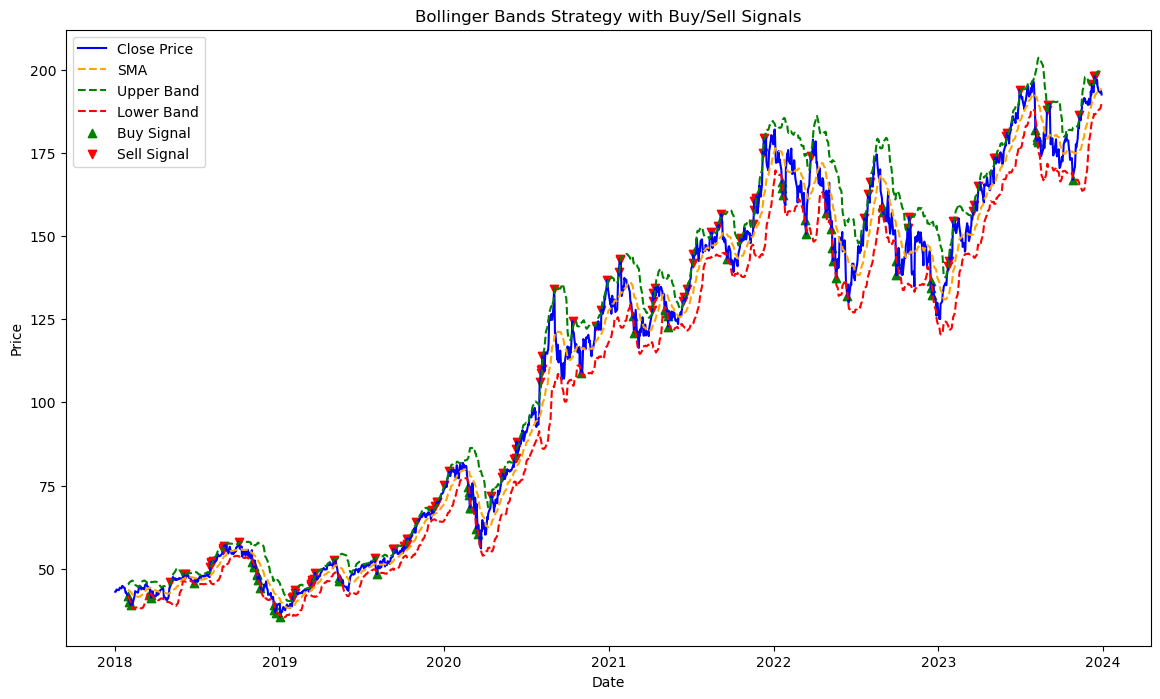

In [60]:
plot_results(data)

[*********************100%***********************]  1 of 1 completed



Trade Details:
                    Buy Date   Buy Price  Sell Price  Profit/Loss
0  2018-01-30 00:00:00+00:00   41.742500   45.957500     4.215000
1  2018-02-02 00:00:00+00:00   40.125000   45.957500     5.832500
2  2018-02-05 00:00:00+00:00   39.122501   45.957500     6.834999
3  2018-03-21 00:00:00+00:00   42.817501   45.957500     3.139999
4  2018-03-22 00:00:00+00:00   42.212502   45.957500     3.744999
5  2018-03-23 00:00:00+00:00   41.235001   45.957500     4.722500
6  2018-06-25 00:00:00+00:00   45.542500   50.375000     4.832500
7  2018-11-02 00:00:00+00:00   51.869999   41.312500   -10.557499
8  2018-11-05 00:00:00+00:00   50.397499   41.312500    -9.084999
9  2018-11-06 00:00:00+00:00   50.942501   41.312500    -9.630001
10 2018-11-12 00:00:00+00:00   48.542500   41.312500    -7.230000
11 2018-11-13 00:00:00+00:00   48.057499   41.312500    -6.744999
12 2018-11-14 00:00:00+00:00   46.700001   41.312500    -5.387501
13 2018-11-20 00:00:00+00:00   44.244999   41.312500    -2.9

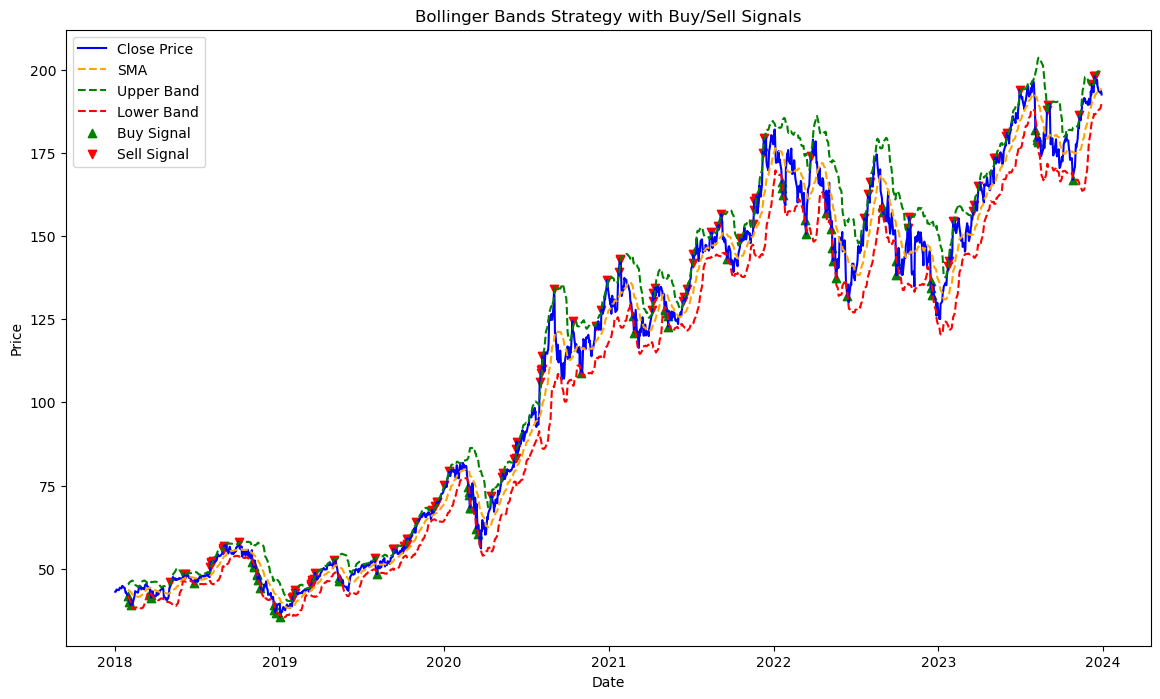

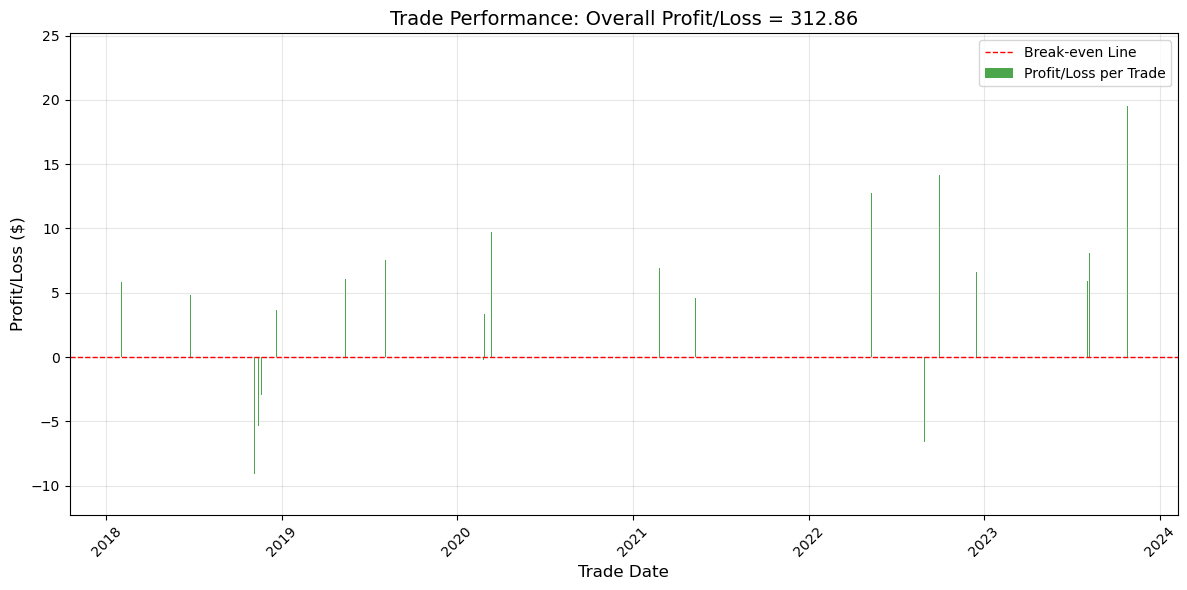

In [48]:
import matplotlib.pyplot as plt

def plot_trade_details(trades_df):
    """
    Plot a graphical representation of trade details.
    """
    if not trades_df.empty:
        plt.figure(figsize=(12, 6))

        # Bar plot for individual trade profits/losses
        plt.bar(trades_df['Buy Date'], trades_df['Profit/Loss'], color='green', alpha=0.7, label='Profit/Loss per Trade')

        # Highlight overall profit/loss
        overall_profit = trades_df['Profit/Loss'].sum()
        plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even Line')
        plt.title(f'Trade Performance: Overall Profit/Loss = {overall_profit:.2f}', fontsize=14)

        # Add labels
        plt.xlabel('Trade Date', fontsize=12)
        plt.ylabel('Profit/Loss ($)', fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("No trades to plot.")

# Main script
if __name__ == "__main__":
    symbol = 'AAPL'  # Replace with your stock symbol
    start_date = '2018-01-01'
    end_date = '2023-12-31'

    # Download data
    data = fetch_data(symbol, start_date, end_date)
    
    if not data.empty:
        try:
            # Flatten MultiIndex columns
            data = flatten_columns(data)
            
            # Calculate Bollinger Bands
            data = calculate_bollinger_bands(data)

            # Generate buy and sell signals
            data = generate_signals(data)

            # Collect buy and sell signals
            buy_signals = data[['Buy Signal']].dropna()
            sell_signals = data[['Sell Signal']].dropna()

            # Pair buy and sell signals and calculate profit/loss
            trades = []
            for buy_date, buy_price in buy_signals.iterrows():
                corresponding_sells = sell_signals[sell_signals.index > buy_date]
                if not corresponding_sells.empty:
                    sell_date = corresponding_sells.index[0]
                    sell_price = corresponding_sells.loc[sell_date, 'Sell Signal']
                    profit_or_loss = sell_price - buy_price['Buy Signal']
                    trades.append({
                        'Buy Date': buy_date,
                        'Buy Price': buy_price['Buy Signal'],
                        #'Sell Date': sell_date,
                        'Sell Price': sell_price,
                        'Profit/Loss': profit_or_loss
                    })

            # Convert trades to DataFrame for better visualization
            trades_df = pd.DataFrame(trades)

            # Calculate overall profit/loss
            overall_profit_or_loss = trades_df['Profit/Loss'].sum()

            # Output results
            print("\nTrade Details:")
            print(trades_df)
            print(f"\nOverall Profit/Loss: {overall_profit_or_loss}")

            # Plot results
            plot_results(data)

            # Plot trade details
            plot_trade_details(trades_df)
        except Exception as e:
            print("An error occurred:", e)
    else:
        print("No data retrieved. Check the stock symbol and date range.")
